# **Import**

In [ ]:
!pip3 install wandb matplotlib torch torchviz torchvision torchsummary torchviz weave nbformat --quiet

import os
from os import path
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchviz import make_dot
from torchsummary import summary
import torch.utils.data as data
from PIL import Image, ImageDraw
from torchvision import datasets, transforms, utils
import wandb

# **Util Functions**

In [ ]:
def show_image(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, labels

def show_image_with_labels(image, labels, class_names=None):
    image_np = image.permute(1, 2, 0).numpy()
    h, w, _ = image_np.shape

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image_np)

    for label in labels:
        class_id, x_center, y_center, bw, bh = label.tolist()
        x = (x_center - bw / 2) * w
        y = (y_center - bh / 2) * h
        box_w = bw * w
        box_h = bh * h
        rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        if class_names:
            class_text = class_names[int(class_id)]
        else:
            class_text = str(int(class_id))
        ax.text(x, y - 5, class_text, color='white', fontsize=12,bbox=dict(facecolor='red', alpha=0.5, pad=2))
    plt.axis('off')
    plt.show()


classes_types = {
    0: 'cow',
    1: 'duck',
    2: 'flower',
    3: 'people',
    4: 'pig',
    5: 'rabbit',
    6: 'sheep',
}
classes_number = len(classes_types)

# **Dataset**

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from os import path

class MinecraftV1(Dataset):
    def __init__(self, root, train=True, valid=False, transform=None):
        super().__init__()
        
        self.root = root
        self.train = train
        self.valid = valid
        self.transform = transform

        if train:
            self.data_path = path.join(root, 'train')
        elif valid:
            self.data_path = path.join(root, 'valid')
        else:
            self.data_path = path.join(root, 'test')
        
        self.images_path = path.join(self.data_path, 'images')
        self.labels_path = path.join(self.data_path, 'labels')
        self.data_images = []
        self.data_labels = []
        image_files = os.listdir(self.images_path)
        label_files = os.listdir(self.labels_path)
        for image_file in image_files:
            image_path = path.join(self.images_path, image_file)
            self.data_images.append(image_path)

        for label_file in label_files:
            label_path = path.join(self.labels_path,label_file)
            self.data_labels.append(label_path)

    def __len__(self):
        return len(self.data_images)
        
    def __getitem__(self, idx):
        image_path = self.data_images[idx]
        label_path = self.data_labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        with open(label_path, 'r') as file:
            lines = file.readlines()
        labels = [list(map(float, line.strip().split())) for line in lines]
        labels = torch.tensor(labels, dtype=torch.float32)

        return image, labels
    
basic_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

mc_train = MinecraftV1(root=os.getcwd(), transform=basic_transform)
mc_test = MinecraftV1(root=os.getcwd(), train=False, transform=basic_transform)
mc_valid = MinecraftV1(root=os.getcwd(), train=False,valid=True, transform=basic_transform)


# **DataLoader**

In [ ]:
trainloader = data.DataLoader(mc_train, batch_size=4, shuffle=True, collate_fn=collate_fn)
images, labels = next(iter(trainloader))
for i in range(4):
    show_image_with_labels(images[i], labels[i], class_names=None)

validloader = data.DataLoader(mc_valid, batch_size=4, shuffle=True, collate_fn=collate_fn)

# **Device**

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

# **Yolo V5**

## Architecture

In [ ]:
# CBS (Convolutional + BatchNorm + SiLU)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    def forward(self, x):
        return self.conv(x)

# Focus block for improved small details detection
class FocusBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size =3, stride=1):
        super().__init__()
        self.conv = ConvBlock(in_channels * 4, out_channels, kernel_size, stride)

    def forward(self, x):
        x = torch.cat([x[:, :, ::2, ::2],
                       x[:, :, 1::2, ::2],
                       x[:, :, ::2, 1::2],
                       x[:, :, 1::2, 1::2]], dim=1)
        return self.conv(x)
    
# CSPNet
class CSP(nn.Module):
    def __init__(self, in_channels, out_channels,num_blocks):
        super().__init__()
        hidden_channels = out_channels // 2
        self.conv1 = ConvBlock(in_channels, hidden_channels,1)
        self.conv2 = ConvBlock(in_channels, hidden_channels,1 )
        self.blocks = nn.Sequential(*[
            ConvBlock(hidden_channels, hidden_channels, 3)
            for _ in range(num_blocks)
        ])
        self.conv3 = ConvBlock(2*hidden_channels, out_channels,1)
    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x1 = self.blocks(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv3(x)

# Spatial Pyramid Pooling Fast
class SPPF(nn.Module):
    def __init__(self, in_channels, out_channels, k = 5):
        super().__init__()
        hidden_channels = in_channels // 2
        self.conv1 = ConvBlock(in_channels, hidden_channels,1 )
        self.conv2 = ConvBlock(hidden_channels * 4, out_channels,1)
        self.pools = nn.ModuleList([nn.MaxPool2d(kernel_size=k, stride=1, padding=k//2) for _ in range(3)])

    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(torch.cat([x] + [pool(x) for pool in self.pools], 1))

# Backbone
class DarkNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = FocusBlock(3, 32, 3, 1)
        self.layer1 = nn.Sequential(
            ConvBlock(32, 64, 3, 2),
            CSP(64, 64,1)
        )
        self.layer2 = nn.Sequential(
            ConvBlock(64, 128, 3, 2),
            CSP(128, 128,2)
        )
        self.layer3 = nn.Sequential(
            ConvBlock(128, 256, 3, 2),
            CSP(256, 256,3)
        )
        self.layer4 = nn.Sequential(
            ConvBlock(256, 512, 3, 2),
            CSP(512, 512,1),
            SPPF(512, 1024)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        out = self.layer2(x)
        out2 = self.layer3(out)
        out3 = self.layer4(out2)
        return out, out2, out3

# Neck
class PANet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv5_reduce = ConvBlock(1024, 512, 1)
        self.conv4_reduce = ConvBlock(256, 512, 1)
        self.csp4_td = CSP(1024, 256, num_blocks=1)

        self.conv4_reduce2 = ConvBlock(256, 128, 1)
        self.conv3_reduce = ConvBlock(128, 128, 1)
        self.csp3_td = CSP(256, 128, num_blocks=1)

        self.conv3_down = ConvBlock(128, 128, 3, stride=2)
        self.csp4_bu = CSP(384, 256, num_blocks=1)

        self.conv4_down = ConvBlock(256, 256, 3, stride=2)
        self.csp5_bu = CSP(768, 512, num_blocks=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x3, x4, x5):
        p5 = self.conv5_reduce(x5)
        p5_up = self.upsample(p5)
        p4 = self.conv4_reduce(x4)
        p4_td = self.csp4_td(torch.cat([p5_up, p4], dim=1))

        p4_red = self.conv4_reduce2(p4_td)
        p4_up = self.upsample(p4_red)
        p3 = self.conv3_reduce(x3)
        p3_td = self.csp3_td(torch.cat([p4_up, p3], dim=1))

        p3_down = self.conv3_down(p3_td)
        p4_bu = self.csp4_bu(torch.cat([p3_down, p4_td], dim=1))

        p4_down = self.conv4_down(p4_bu)
        p5_bu = self.csp5_bu(torch.cat([p4_down, p5], dim=1))

        return p3_td, p4_bu, p5_bu

# Head
class HeadDetection(nn.Module):
    def __init__(self, in_channels,num_classes,anchor):
        super().__init__()
        self.num_classes = num_classes
        self.anchor = anchor
        self.conv = ConvBlock(in_channels, in_channels * 2,3)
        self.final_conv = nn.Conv2d(in_channels * 2, (num_classes + 5) * anchor, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        x = self.conv(x)
        x = self.final_conv(x)
        bs, _, h, w = x.shape
        x = x.view(bs, self.anchor, self.num_classes + 5, h, w)
        return x.permute(0,1,3,4,2)

class YOLOv5(nn.Module):

    def __init__(self, num_classes, anchors = None):
        super().__init__()
        self.backbone = DarkNet()
        self.neck = PANet()
        self.num_classes = num_classes

        if anchors is None:
            self.anchors = torch.tensor([
                [[10, 13], [16, 30], [33, 23]],
                [[30, 61], [62, 45], [59, 119]],
                [[116, 90], [156, 198], [373, 326]]
            ], dtype=torch.float32)
        else:
            self.anchors = anchors
        
        self.head_small = HeadDetection(128, num_classes, 3)
        self.head_medium = HeadDetection(256, num_classes, 3)
        self.head_large = HeadDetection(512, num_classes, 3)#Ne supporte pas 512

    def forward(self, x):
        out1, out2, out3 = self.backbone(x)
        new_out1, new_out2, new_out3 = self.neck(out1, out2, out3)
        y_small = self.head_small(new_out1)
        y_medium = self.head_medium(new_out2)
        y_large = self.head_large(new_out3)
        return [y_small, y_medium, y_large]



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv5(num_classes=classes_number).to(device)

summary(model, (3, 640, 640), device=str(device))


from torchviz import make_dot

params = {name: param for name, param in model.named_parameters() if isinstance(param, torch.Tensor)}

x = torch.randn(1, 3, 640, 640).to(device)
y = model(x)

make_dot(y[0], params=dict(model.named_parameters())).render("yolov5_arch", format="png")


In [ ]:
model = YOLOv5(num_classes=classes_number).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def build_targets(labels, anchors, grid_sizes, num_classes, device):
    num_scales = 3
    targets = []
    for scale_idx in range(num_scales):
        grid_size = grid_sizes[scale_idx]
        stride = 640 / grid_size
        current_anchors = anchors[scale_idx]
        target = torch.zeros((len(labels), len(current_anchors), grid_size, grid_size, 6), device=device)
        
        for batch_idx, label in enumerate(labels):
            if label.numel() == 0:
                continue
            gt_boxes = label[:, 1:5] * 640
            gt_classes = label[:, 0].long()
            x_center = gt_boxes[:, 0]
            y_center = gt_boxes[:, 1]
            w = gt_boxes[:, 2]
            h = gt_boxes[:, 3]
            
            for box_idx in range(gt_boxes.shape[0]):
                x = x_center[box_idx]
                y = y_center[box_idx]
                box_w = w[box_idx]
                box_h = h[box_idx]
                
                # Find best anchor
                current_anchors_tensor = torch.tensor(current_anchors, device=device)
                ratios = torch.cat([box_w / current_anchors_tensor[:, 0],
                                  box_h / current_anchors_tensor[:, 1]]).view(2, -1).T
                max_ratios = torch.max(ratios, 1/ratios).max(dim=1)[0]
                best_anchor = max_ratios.argmin()
                
                # Grid cell
                i = (x / stride).floor().long()
                j = (y / stride).floor().long()
                if i >= grid_size or j >= grid_size or i < 0 or j < 0:
                    continue
                
                # Target values
                tx = (x / stride) - i.float()
                ty = (y / stride) - j.float()
                tw = torch.log(box_w / current_anchors_tensor[best_anchor, 0] + 1e-16)
                th = torch.log(box_h / current_anchors_tensor[best_anchor, 1] + 1e-16)
                
                target[batch_idx, best_anchor, j, i, 0] = 1.0  # obj
                target[batch_idx, best_anchor, j, i, 1] = tx
                target[batch_idx, best_anchor, j, i, 2] = ty
                target[batch_idx, best_anchor, j, i, 3] = tw
                target[batch_idx, best_anchor, j, i, 4] = th
                target[batch_idx, best_anchor, j, i, 5] = gt_classes[box_idx]
                
        targets.append(target)
    return targets

def compute_loss(outputs, targets):
    total_loss = 0.0
    obj_loss = 0.0
    box_loss = 0.0
    cls_loss = 0.0
    
    for y_pred, target in zip(outputs, targets):
        # Predicted components
        pred_tx = y_pred[..., 0]
        pred_ty = y_pred[..., 1]
        pred_tw = y_pred[..., 2]
        pred_th = y_pred[..., 3]
        pred_obj = y_pred[..., 4]
        pred_cls = y_pred[..., 5:]
        
        # Target components
        target_obj = target[..., 0]
        target_tx = target[..., 1]
        target_ty = target[..., 2]
        target_tw = target[..., 3]
        target_th = target[..., 4]
        target_cls = target[..., 5].long()
        
        # Objectness loss
        obj_mask = target_obj.bool()
        obj_loss += F.binary_cross_entropy_with_logits(pred_obj, target_obj)
        
        # Box loss (only where objects exist)
        if obj_mask.sum():
            box_loss += F.mse_loss(pred_tx[obj_mask], target_tx[obj_mask]) + \
                       F.mse_loss(pred_ty[obj_mask], target_ty[obj_mask]) + \
                       F.mse_loss(pred_tw[obj_mask], target_tw[obj_mask]) + \
                       F.mse_loss(pred_th[obj_mask], target_th[obj_mask])
        
        # Class loss
        if obj_mask.sum():
            cls_loss += F.cross_entropy(pred_cls[obj_mask], target_cls[obj_mask])
    
    total_loss = obj_loss + box_loss + cls_loss
    return total_loss, obj_loss, box_loss, cls_loss


# Training

In [ ]:
num_epochs = 20

run = wandb.init(
    entity="s-gardier-work",
    project="yolov5",
    config={
        "architecture": "YOLOv5",
        "dataset": "https://universe.roboflow.com/yolo-minecraft/minecraft-ogpjp/dataset/10",
        "epochs": num_epochs,
    },
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = YOLOv5(num_classes=classes_number).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        
        # Generate targets
        anchors = model.anchors.cpu().numpy().tolist()
        grid_sizes = [80, 40, 20]
        targets = build_targets(labels, anchors, grid_sizes, classes_number, device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        total_loss, obj_loss, box_loss, cls_loss = compute_loss(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")
    epoch_loss = running_loss / len(trainloader)

    # Save model checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"yolov5_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")
    model.eval()
    val_running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(validloader):
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        
        # Generate targets
        anchors = model.anchors.cpu().numpy().tolist()
        grid_sizes = [80, 40, 20]
        targets = build_targets(labels, anchors, grid_sizes, classes_number, device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        total_loss, obj_loss, box_loss, cls_loss = compute_loss(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        val_running_loss += total_loss.item()
    print(f"Validation Loss: {val_running_loss / len(validloader):.4f}")
    run.log({"epoch": (epoch + 1)/num_epochs, "training_loss": running_loss / len(trainloader), "validation_loss": val_running_loss / len(validloader)})

run.finish()


# Inference

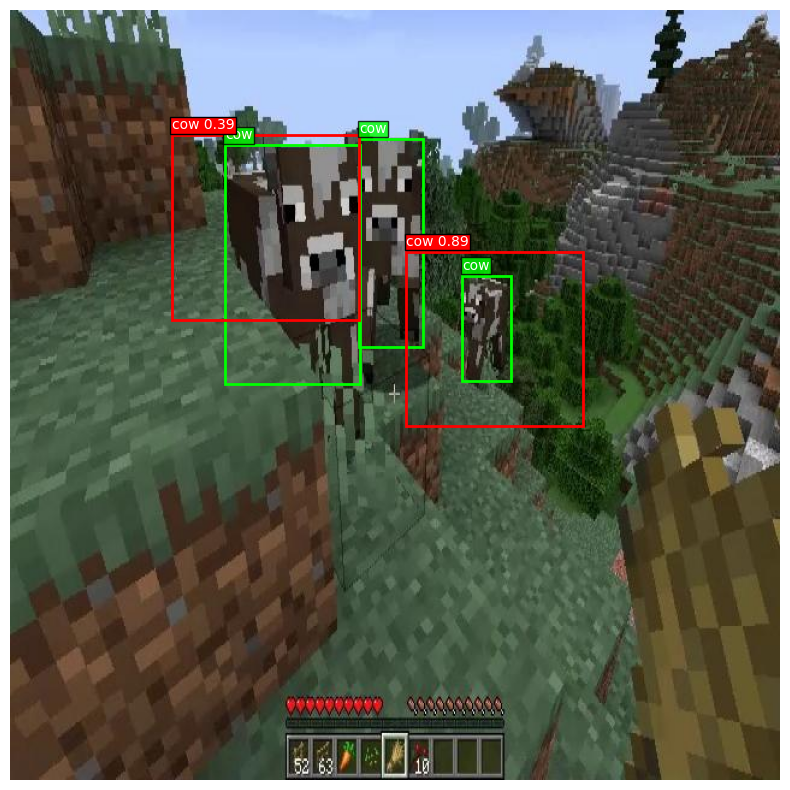

In [ ]:
def load_model(model, model_path="models/yolov5_epoch_20.pth"):
    """Load a model from a .pth file."""
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def decode_predictions(outputs, confidence_thresh=0.1, iou_thresh=0.1):
    """Convert model outputs to usable bounding boxes"""
    all_boxes = []
    anchors = model.anchors.cpu().numpy()
    strides = [8, 16, 32]  # For 640x640 input
    
    for scale_idx, output in enumerate(outputs):
        # Convert to numpy and get dimensions
        output = output.sigmoid().cpu().detach().numpy()
        bs, num_anchors, h, w, _ = output.shape
        
        # Convert dimensions to integers
        h = int(h)
        w = int(w)
        
        # Get parameters for this scale
        stride = strides[scale_idx]
        anchor = anchors[scale_idx]
        
        # Create grid
        grid_y, grid_x = np.mgrid[:h, :w]

        # Reshape output for vectorized operations
        output = output.reshape(bs, num_anchors, h, w, -1)
        
        # Decode predictions using vectorized operations
        tx = output[..., 0]
        ty = output[..., 1]
        tw = output[..., 2]
        th = output[..., 3]
        obj = output[..., 4]
        cls_probs = output[..., 5:]
        
        # Calculate absolute coordinates
        x = (grid_x + tx) * stride
        y = (grid_y + ty) * stride
        w = anchor[:, 0].reshape(1, -1, 1, 1) * np.exp(tw)
        h = anchor[:, 1].reshape(1, -1, 1, 1) * np.exp(th)
        
        # Calculate class confidence
        class_ids = np.argmax(cls_probs, axis=-1)
        class_conf = np.take_along_axis(cls_probs, class_ids[..., None], axis=-1).squeeze(-1)
        confidence = obj * class_conf

        # Filter by confidence threshold
        mask = confidence > confidence_thresh
        for batch_idx in range(bs):
            batch_mask = mask[batch_idx]
            batch_boxes = np.stack([
                x[batch_idx][batch_mask] - w[batch_idx][batch_mask]/2,
                y[batch_idx][batch_mask] - h[batch_idx][batch_mask]/2,
                x[batch_idx][batch_mask] + w[batch_idx][batch_mask]/2,
                y[batch_idx][batch_mask] + h[batch_idx][batch_mask]/2,
                confidence[batch_idx][batch_mask],
                class_ids[batch_idx][batch_mask]
            ], axis=-1)
            
            if batch_boxes.size > 0:
                all_boxes.extend(batch_boxes.tolist())

    # Non-Maximum Suppression
    if not all_boxes:
        return []

    boxes = np.array(all_boxes)
    x1, y1, x2, y2, scores, class_ids = boxes.T

    # Calculate areas and sort
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)
        
        # Calculate overlaps
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        intersection = w * h
        
        iou = intersection / (areas[i] + areas[order[1:]] - intersection)
        
        # Filter boxes
        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]

    return boxes[keep].tolist()

def test_single_image(model, dataset, index=0):
    # Get image and labels
    image, true_labels = dataset[index]
    true_labels = true_labels.cpu().numpy()
    
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(image.unsqueeze(0).to(device))
    
    # Decode predictions
    pred_boxes = decode_predictions(outputs)
    
    # Convert true labels to box format
    true_boxes = []
    img_w, img_h = 640, 640  # Our image size
    for label in true_labels:
        class_id, xc, yc, bw, bh = label
        x = (xc - bw/2) * img_w
        y = (yc - bh/2) * img_h
        w = bw * img_w
        h = bh * img_h
        true_boxes.append([x, y, x+w, y+h, 1.0, class_id])
    
    # Visualize
    image_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_np)
    
    # Draw true boxes (green)
    for box in true_boxes:
        x1, y1, x2, y2, _, class_id = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x1, y1-5, classes_types[int(class_id)],
                color='white', fontsize=10,
                bbox=dict(facecolor='lime', alpha=0.8, pad=1))
    
    # Draw predicted boxes (red)
    for box in pred_boxes:
        x1, y1, x2, y2, conf, class_id = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{classes_types[int(class_id)]} {conf:.2f}",
                color='white', fontsize=10,
                bbox=dict(facecolor='red', alpha=1, pad=1))
    
    plt.axis('off')
    plt.show()

# Test on first validation image
model_from_disk = load_model(model, "models/yolov5_epoch_20.pth")
test_single_image(model_from_disk, mc_valid, index=10)
